# Make a prediction about the coal production

In [2]:
% matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
sns.set()

In [10]:
# Read in our data and promote the 3rd row to the header row and index on the MSHA ID column
df = pd.read_csv("../data/cleaned_coalpublic2013.csv", index_col='MSHA ID')
df.head()

,Year,Mine_Name,Mine_State,Mine_County,Mine_Status,Mine_Type,Company_Type,Operation_Type,Operating_Company,Operating_Company_Address,Union_Code,Coal_Supply_Region,Production_(short_tons),Average_Employees,Labor_Hours,log_production
MSHA ID,,,,,,,,,,,,,,,,
103381,2013,Tacoa Highwall Miner,Alabama,Bibb,"Active, men working, not producing",Surface,Independent Producer Operator,Mine only,"Jesse Creek Mining, Llc","1615 Kent Dairy Rd, Alabaster, AL 35007",,Appalachia Southern,56004,10,22392,10.933178
103404,2013,Reid School Mine,Alabama,Blount,Permanently abandoned,Surface,Independent Producer Operator,Mine only,"Taft Coal Sales & Associates,","3000 Riverchase Galleria Ste 1, Birmingham, AL...",UNIT,Appalachia Southern,28807,18,28447,10.268374
100759,2013,North River #1 Underground Min,Alabama,Fayette,"Active, men working, not producing",Underground,Independent Producer Operator,Mine and Preparation Plant,Jim Walter Resources Inc,"3114 County Rd 63 S, Berry, AL 35546",UNIT,Appalachia Southern,1440115,183,474784,14.180234
103246,2013,Bear Creek,Alabama,Franklin,Active,Surface,Independent Producer Operator,Mine only,"Birmingham Coal & Coke Co., In","912 Edenton Street, Birmingham, AL 35242",,Appalachia Southern,87587,13,29193,11.380388
103451,2013,Knight Mine,Alabama,Franklin,Active,Surface,Independent Producer Operator,Mine only,"Birmingham Coal & Coke Co., In","P.O. Box 354, Lynn, AL 35242",,Appalachia Southern,147499,27,46393,11.901577


In [11]:
len(df)

1061

In [21]:
# List columns
for column in df.columns:
    print(column)

Year
Mine_Name
Mine_State
Mine_County
Mine_Status
Mine_Type
Company_Type
Operation_Type
Operating_Company
Operating_Company_Address
Union_Code
Coal_Supply_Region
Production_(short_tons)
Average_Employees
Labor_Hours


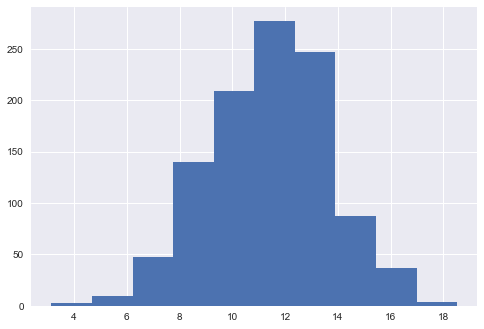

In [37]:
df_nonzero['log_production'].hist()

From our results, it seems that production follows a log-normal distribution.

In [12]:
df.Mine_Status.unique()

array(['Active, men working, not producing', 'Permanently abandoned',
       'Active', 'Temporarily closed', 'New, under construction'], dtype=object)

In [14]:
df[['Mine_Status', 'log_production']].groupby('Mine_Status').mean()

,log_production
Mine_Status,
Active,11.977453
"Active, men working, not producing",10.499962
"New, under construction",3.951244
Permanently abandoned,9.896046
Temporarily closed,9.162933


# Predict the Production of Coal Mines

In [77]:
features = ['Average_Employees',
            'Labor_Hours',
           ]

categoricals = ['Mine_State',
                'Mine_County',
                'Mine_Status',
                'Mine_Type',
                'Company_Type',
                'Operation_Type',
                'Union_Code',
                'Coal_Supply_Region',  
                ]

target = 'log_production'

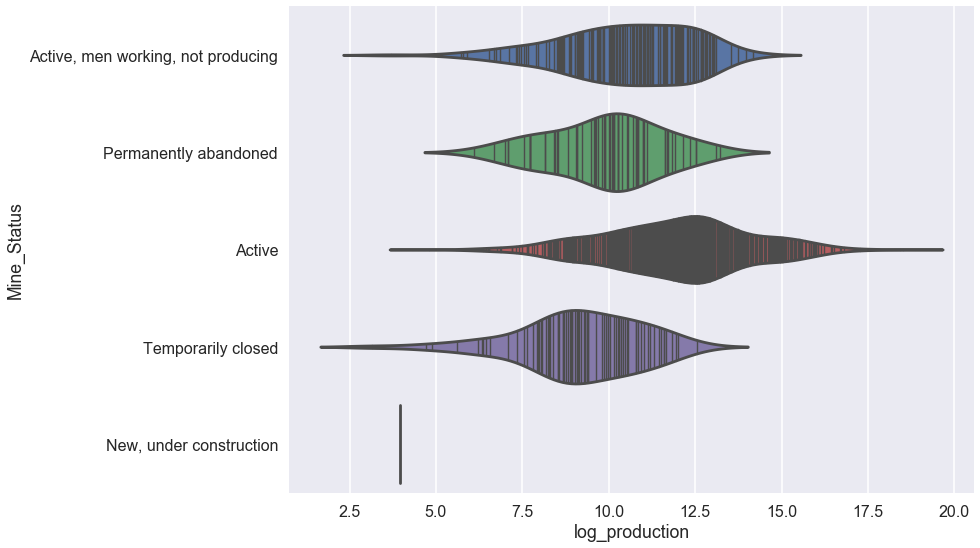

In [53]:
fig = plt.subplots(figsize=(14,8))
sns.set_context('poster')
sns.violinplot(y='Mine_Status', x='log_production', data=df,
               split=True, inner="stick")
plt.tight_layout()

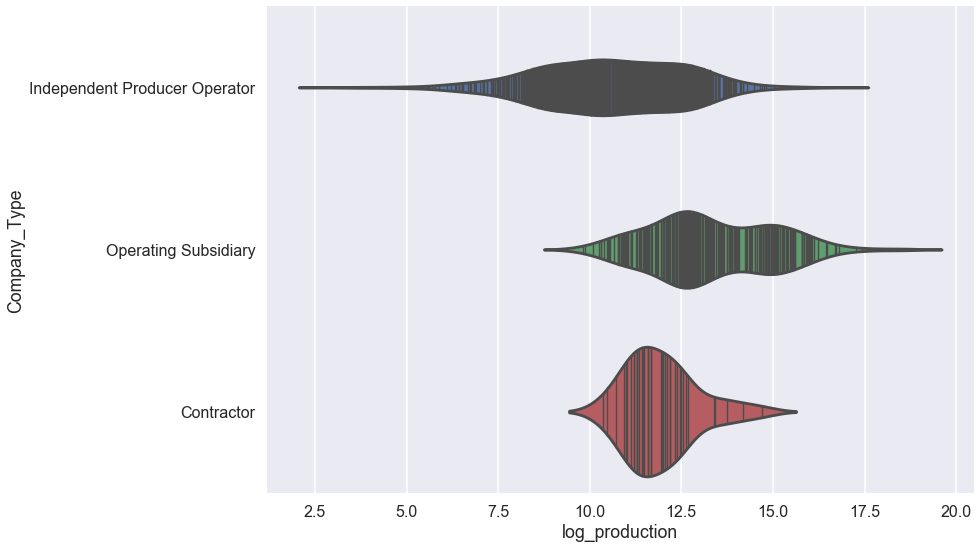

In [54]:
fig = plt.subplots(figsize=(14,8))
sns.set_context('poster')
sns.violinplot(y='Company_Type', x="log_production", data=df,
               split=True, inner="stick")
plt.tight_layout()

Mine_State has 29 categories; violin plot is not suitable for this variable
Mine_County has 164 categories; violin plot is not suitable for this variable


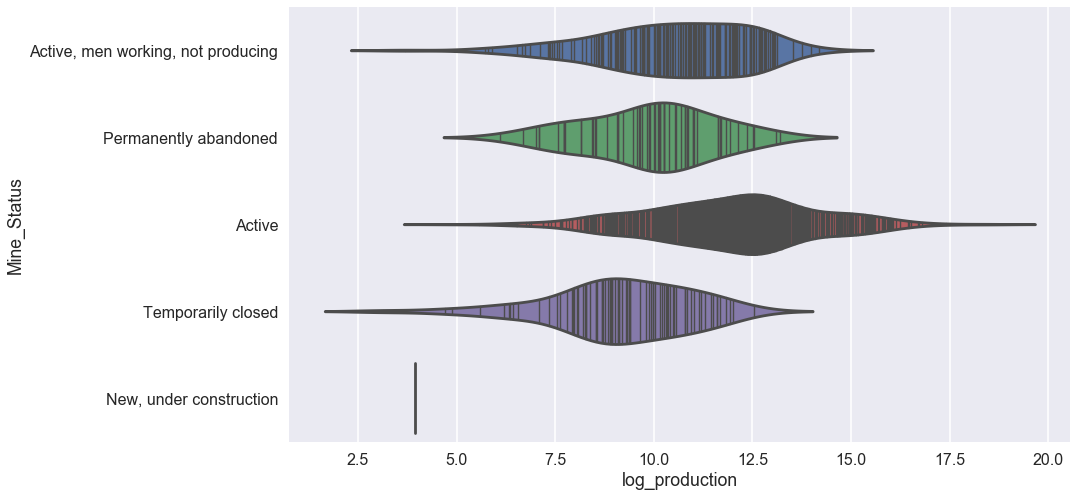

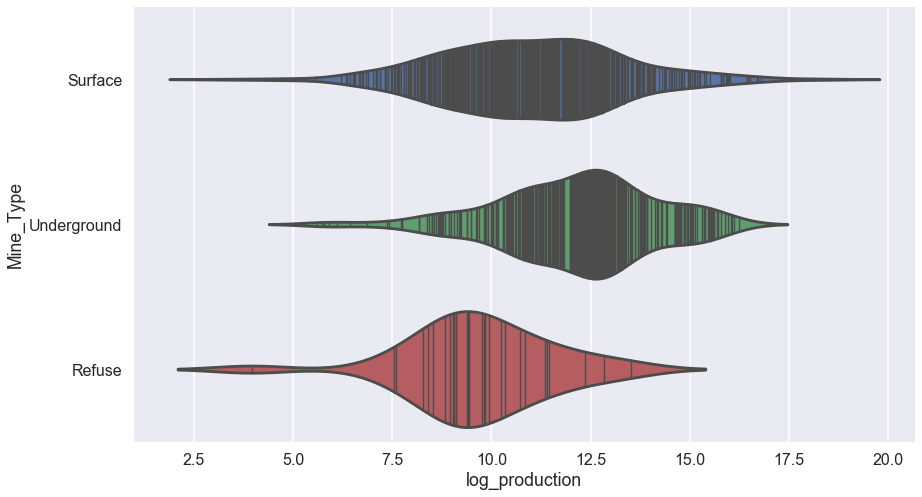

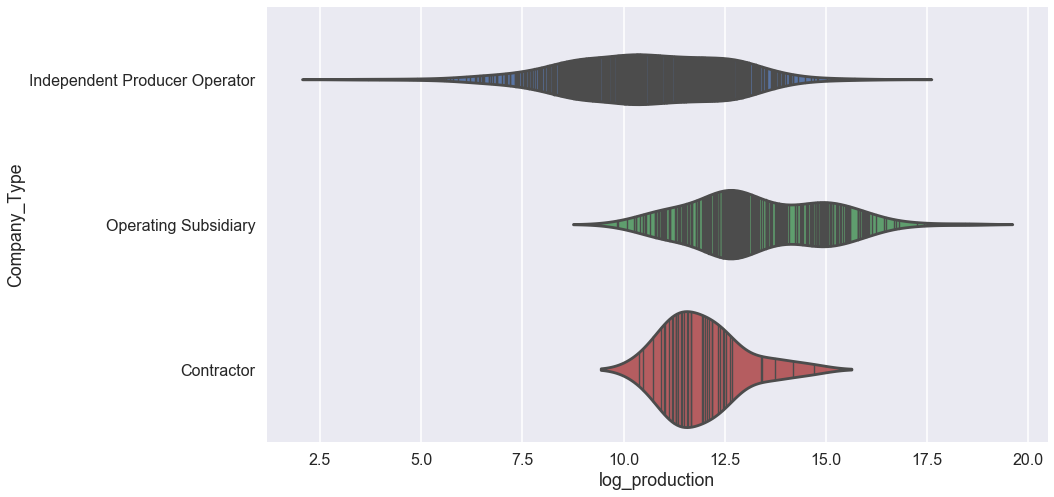

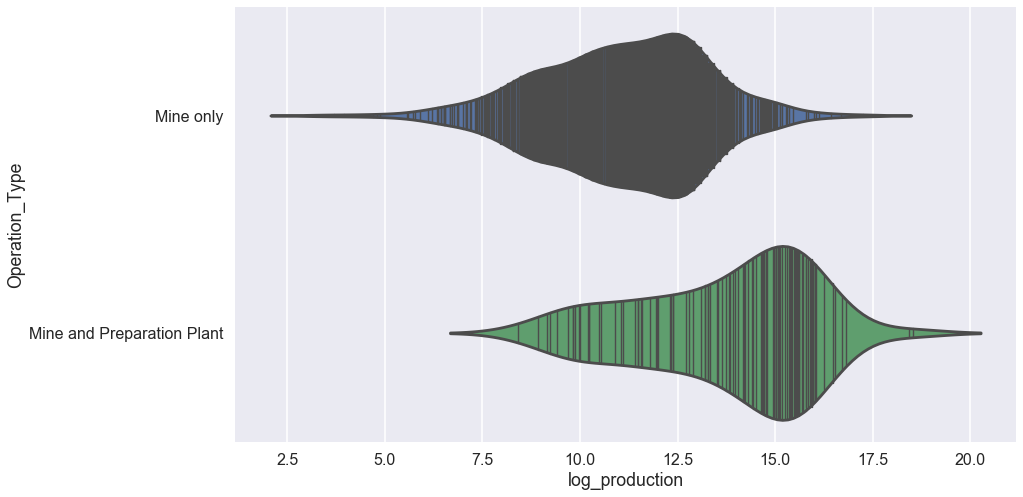

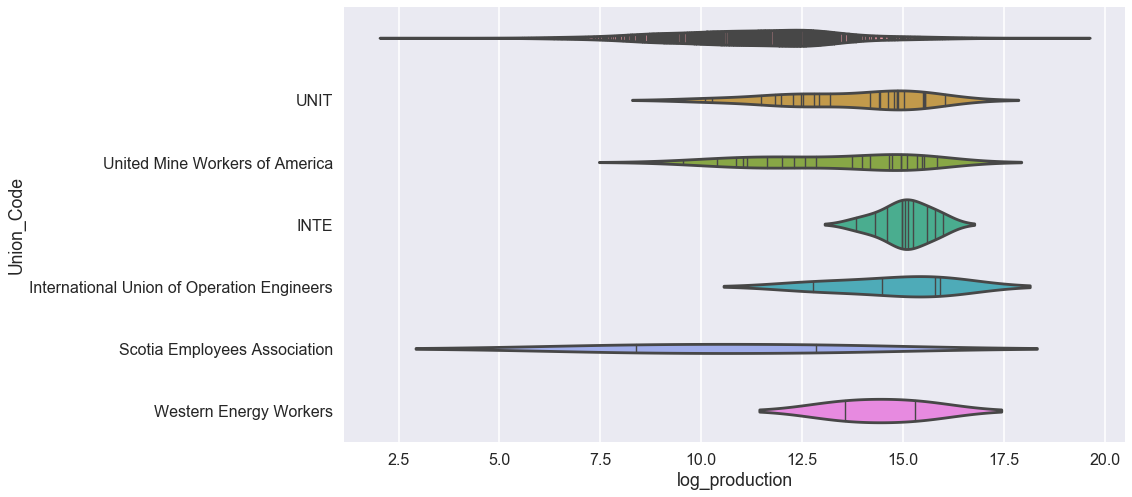

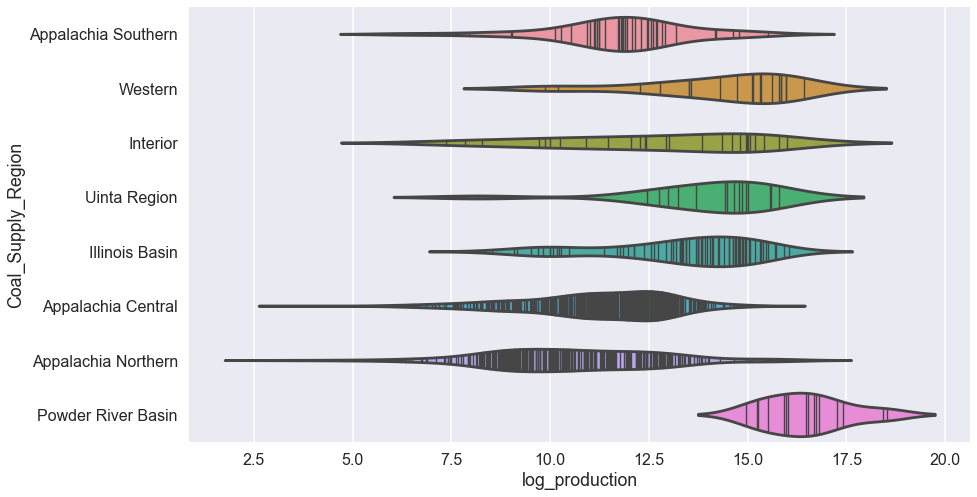

In [55]:
for categorical in categoricals:
    unique_groups = len(df[categorical].unique())
    if unique_groups <= 10:  
        fig = plt.subplots(figsize=(14,8))
        sns.set_context('poster')
        sns.violinplot(y=categorical, x="log_production", data=df,
                       split=True, inner="stick")
    else:
        print(categorical, 'has {} categories; violin plot is not suitable for this variable'.format(unique_groups))
        

In [78]:
df['Company_Type'].unique()

array(['Independent Producer Operator', 'Operating Subsidiary',
       'Contractor'], dtype=object)

In [79]:
pd.get_dummies(df['Company_Type']).sample(50).head()

,Contractor,Independent Producer Operator,Operating Subsidiary
MSHA ID,,,
4609010,0,1,0
3607772,0,1,0
4609163,0,0,1
1518277,0,1,0
3601818,0,1,0


In [80]:
dummy_categoricals = []
for categorical in categoricals:
    print(categorical, len(df[categorical].unique()))
    # Avoid the dummy variable trap!
    drop_var = sorted(df[categorical].unique())[-1]
    temp_df = pd.get_dummies(df[categorical], prefix=categorical)
    df = pd.concat([df, temp_df], axis=1)
    temp_df.drop('_'.join([categorical, str(drop_var)]), axis=1, inplace=True)
    dummy_categoricals += temp_df.columns.tolist()

Mine_State 29
Mine_County 164
Mine_Status 5
Mine_Type 3
Company_Type 3
Operation_Type 2
Union_Code 7
Coal_Supply_Region 8


In [81]:
dummy_categoricals[:10]

['Mine_State_Alabama',
 'Mine_State_Alaska',
 'Mine_State_Arizona',
 'Mine_State_Arkansas',
 'Mine_State_Colorado',
 'Mine_State_Illinois',
 'Mine_State_Indiana',
 'Mine_State_Kansas',
 'Mine_State_Kentucky (East)',
 'Mine_State_Kentucky (West)']

# Build our model

In [82]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [83]:
len(dummy_categoricals)

213

In [84]:
train, test = train_test_split(df, test_size=0.3)

In [85]:
train.head()

,Year,Mine_Name,Mine_State,Mine_County,Mine_Status,Mine_Type,Company_Type,Operation_Type,Operating_Company,Operating_Company_Address,...,Union_Code_United Mine Workers of America,Union_Code_Western Energy Workers,Coal_Supply_Region_Appalachia Central,Coal_Supply_Region_Appalachia Northern,Coal_Supply_Region_Appalachia Southern,Coal_Supply_Region_Illinois Basin,Coal_Supply_Region_Interior,Coal_Supply_Region_Powder River Basin,Coal_Supply_Region_Uinta Region,Coal_Supply_Region_Western
MSHA ID,,,,,,,,,,,,,,,,,,,,,
1519660,2013,No. 7,Kentucky (East),Lawrence,Active,Surface,Independent Producer Operator,Mine only,Mayo Resources Inc,"P.O. Box 190, Lovely, KY 41231",...,0,0,1,0,0,0,0,0,0,0
1519535,2013,Kronos Mine,Kentucky (West),Ohio,Active,Underground,Independent Producer Operator,Mine only,"Armstrong Coal Company, Inc.","Mantanzas Road, Centertown, KY 42323",...,0,0,0,0,0,1,0,0,0,0
4607376,2013,Lost Flat Surface Mine,West Virginia (Southern),Greenbrier,"Active, men working, not producing",Surface,Independent Producer Operator,Mine only,"South Fork Coal Company, Llc","1295 Ashford Hill Road, Ashford, WV 25009",...,0,0,1,0,0,0,0,0,0,0
1519671,2013,Laurel No. 1,Kentucky (East),Laurel,Permanently abandoned,Surface,Independent Producer Operator,Mine only,T&t Coal Inc.,"6283 Hwy 472, Manchester, KY 40962",...,0,0,1,0,0,0,0,0,0,0
1518777,2013,Hazard Job #6,Kentucky (East),Perry,Permanently abandoned,Surface,Independent Producer Operator,Mine only,B & W Resources Inc.,"300 Liperote Way, London, KY 40741",...,0,0,1,0,0,0,0,0,0,0


In [86]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True)

In [87]:
rf.fit(train[features + dummy_categoricals], train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

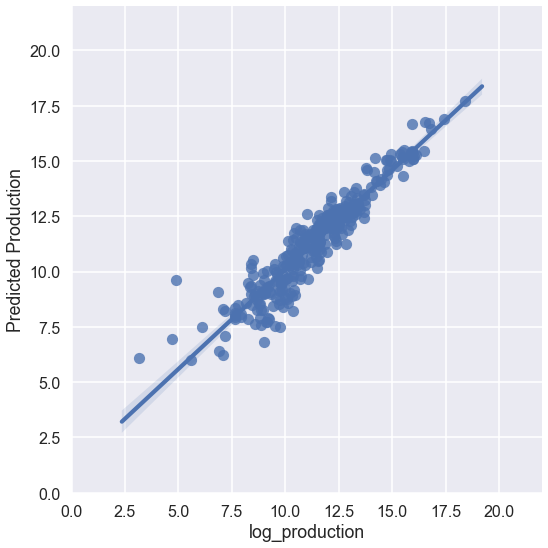

In [89]:
fig = plt.subplots(figsize=(8,8))
sns.regplot(test[target], rf.predict(test[features + dummy_categoricals]))
plt.ylabel("Predicted Production")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.tight_layout()

In [90]:
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error

In [94]:
predicted = rf.predict(test[features + dummy_categoricals])
r2_score(test[target], predicted)

0.88278183076864969

In [95]:
explained_variance_score(test[target], predicted)

0.88323829175932711

In [96]:
mean_squared_error(test[target], predicted)

0.62430684562697036

In [97]:
rf_importances = pd.DataFrame({'name':train[features + dummy_categoricals].columns,
                              'importance':rf.feature_importances_
                             }).sort_values(by='importance', ascending=False).reset_index(drop=True)

rf_importances.head(20)

,importance,name
0,0.852079,Labor_Hours
1,0.048956,Average_Employees
2,0.007057,Mine_Type_Surface
3,0.005911,Coal_Supply_Region_Powder River Basin
4,0.003749,Mine_County_Martin
5,0.003474,Mine_State_West Virginia (Southern)
6,0.003405,Mine_County_Boone
7,0.003043,"Mine_Status_Active, men working, not producing"
8,0.002899,Coal_Supply_Region_Appalachia Central
9,0.002522,Mine_Status_Active
